In [1]:
!pip install sentence-transformers

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [3]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [4]:
#Load the sprag dataset
data = pd.read_csv("refstdcombined.csv")
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0


In [5]:
data = data.dropna()

In [6]:
#### Just some code to print debug information to stdout
import logging
from sentence_transformers import LoggingHandler
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [7]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['max_score'].values

# Dropping labels column from data
data = data.drop(['max_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, random_state=42, test_size=0.2)

In [8]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)

  for idxA in range(len(sentence1)):      
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])
    
		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))

     
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [9]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['ReferenceAnswer'].values.tolist()
x_train_sA = train_data['StudentAnswer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [10]:
#use test dataset as dev dataset
x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels / 5.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = [] 
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples)

In [11]:
train_examples = [] 
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

In [12]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/training_sprag_v2_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [13]:
from sentence_transformers import evaluation
import math

def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
  model = SentenceTransformer(st_model)
  #for evaluation
  train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
  test_evaluator = evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)

  #configuring the training
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
  print(warmup_steps)
  #train_loss = losses.CosineSimilarityLoss(model)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=test_evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,  
          #evaluation_steps=50, 
          output_path=model_save_path,)
  print("Training done...")

###Training - 1
#### stsb-distilbert-base

In [14]:
st_model = 'stsb-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 21:20:21 - Load pretrained SentenceTransformer: stsb-distilbert-base
2022-07-18 21:20:21 - Use pytorch device: cuda
2022-07-18 21:20:21 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:20:40 - Evaluation on the  dataset after epoch 0:
2022-07-18 21:20:42 - Accuracy: 0.4439 (356/802)

2022-07-18 21:20:42 - Save model to output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:20:58 - Evaluation on the  dataset after epoch 1:
2022-07-18 21:21:00 - Accuracy: 0.4913 (394/802)

2022-07-18 21:21:00 - Save model to output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:21:16 - Evaluation on the  dataset after epoch 2:
2022-07-18 21:21:18 - Accuracy: 0.5299 (425/802)

2022-07-18 21:21:18 - Save model to output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:21:34 - Evaluation on the  dataset after epoch 3:
2022-07-18 21:21:36 - Accuracy: 0.5312 (426/802)

2022-07-18 21:21:36 - Save model to output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:21:52 - Evaluation on the  dataset after epoch 4:
2022-07-18 21:21:54 - Accuracy: 0.5411 (434/802)

2022-07-18 21:21:54 - Save model to output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:22:11 - Evaluation on the  dataset after epoch 5:
2022-07-18 21:22:12 - Accuracy: 0.5312 (426/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:22:28 - Evaluation on the  dataset after epoch 6:
2022-07-18 21:22:30 - Accuracy: 0.5486 (440/802)

2022-07-18 21:22:30 - Save model to output/stsb-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:22:47 - Evaluation on the  dataset after epoch 7:
2022-07-18 21:22:48 - Accuracy: 0.5349 (429/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:23:04 - Evaluation on the  dataset after epoch 8:
2022-07-18 21:23:06 - Accuracy: 0.5424 (435/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:23:22 - Evaluation on the  dataset after epoch 9:
2022-07-18 21:23:23 - Accuracy: 0.5474 (439/802)

Training done...



                     ********** stsb-distilbert-base **********
2022-07-18 21:23:23 - Load pretrained SentenceTransformer: output/stsb-distilbert-base
2022-07-18 21:23:24 - Use pytorch device: cuda
2022-07-18 21:23:24 - Softmax loss: #Vectors concatenated: 3
2022-07-18 21:23:24 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 21:23:26 - Cosine-Similarity :	Pearson: 0.7213	Spearman: 0.7549
2022-07-18 21:23:26 - Manhattan-Distance:	Pearson: 0.7049	Spearman: 0.7573
2022-07-18 21:23:26 - Euclidean-Distance:	Pearson: 0.7046	Spearman: 0.7567
2022-07-18 21:23:26 - Dot-Product-Similarity:	Pearson: 0.7207	Spearman: 0.7541

Training Accuracy
2022-07-18 21:23:26 - Evaluation on the  dataset:
2022-07-18 21:23:31 - Accuracy: 0.1029 (330/3208)


Test Accuracy
2022-07-18 21:23:31 - Evaluation on the  dataset:
2022-07-18 21:23:32 - 

0.11471321695760599

### Experiment-2
####all-MiniLM-L6-v2

In [15]:
st_model = 'sentence-transformers/all-MiniLM-L6-v2'
num_epochs = 10
batch_size=16
model_save_path = "output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 21:23:54 - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2022-07-18 21:23:54 - Use pytorch device: cuda
2022-07-18 21:23:54 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:24:10 - Evaluation on the  dataset after epoch 0:
2022-07-18 21:24:11 - Accuracy: 0.3392 (272/802)

2022-07-18 21:24:11 - Save model to output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:24:28 - Evaluation on the  dataset after epoch 1:
2022-07-18 21:24:29 - Accuracy: 0.4077 (327/802)

2022-07-18 21:24:29 - Save model to output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:24:45 - Evaluation on the  dataset after epoch 2:
2022-07-18 21:24:46 - Accuracy: 0.4239 (340/802)

2022-07-18 21:24:46 - Save model to output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:25:03 - Evaluation on the  dataset after epoch 3:
2022-07-18 21:25:04 - Accuracy: 0.4439 (356/802)

2022-07-18 21:25:04 - Save model to output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:25:20 - Evaluation on the  dataset after epoch 4:
2022-07-18 21:25:22 - Accuracy: 0.4688 (376/802)

2022-07-18 21:25:22 - Save model to output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:25:38 - Evaluation on the  dataset after epoch 5:
2022-07-18 21:25:39 - Accuracy: 0.4950 (397/802)

2022-07-18 21:25:39 - Save model to output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:25:56 - Evaluation on the  dataset after epoch 6:
2022-07-18 21:25:57 - Accuracy: 0.4925 (395/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:26:13 - Evaluation on the  dataset after epoch 7:
2022-07-18 21:26:14 - Accuracy: 0.4963 (398/802)

2022-07-18 21:26:14 - Save model to output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:26:31 - Evaluation on the  dataset after epoch 8:
2022-07-18 21:26:32 - Accuracy: 0.5112 (410/802)

2022-07-18 21:26:32 - Save model to output/sentence-transformers/all-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:26:48 - Evaluation on the  dataset after epoch 9:
2022-07-18 21:26:49 - Accuracy: 0.5150 (413/802)

2022-07-18 21:26:49 - Save model to output/sentence-transformers/all-MiniLM-L6-v2
Training done...



                     ********** sentence-transformers/all-MiniLM-L6-v2 **********
2022-07-18 21:26:50 - Load pretrained SentenceTransformer: output/sentence-transformers/all-MiniLM-L6-v2
2022-07-18 21:26:50 - Use pytorch device: cuda
2022-07-18 21:26:50 - Softmax loss: #Vectors concatenated: 3
2022-07-18 21:26:50 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 21:26:51 - Cosine-Similarity :	Pearson: 0.5713	Spearman: 0.6076
2022-07-18 21:26:51 - Manhattan-Distance:	Pearson: 0.5787	Spearman: 0.6167
2022-07-18 21:26:51 - Euclidean-Distance:	Pearson: 0.5688	Spearman: 0.6076
2022-07-18 21:26:51 - Dot-Product-Similarity:	Pearson: 0.5713	Spearman: 0.6076

Training Accuracy
2022-07-18 21:26:51 - Evaluation on the  dataset:
2022-07-18 21:26:56 

0.2855361596009975

###Experiment-3
####multi-qa-MiniLM-L6-cos-v1

In [16]:
st_model = 'sentence-transformers/multi-qa-MiniLM-L6-cos-v1'
num_epochs = 10
batch_size=16
model_save_path = "multi_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 21:27:02 - Load pretrained SentenceTransformer: sentence-transformers/multi-qa-MiniLM-L6-cos-v1
2022-07-18 21:27:02 - Use pytorch device: cuda
2022-07-18 21:27:02 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:27:18 - Evaluation on the  dataset after epoch 0:
2022-07-18 21:27:19 - Accuracy: 0.2880 (231/802)

2022-07-18 21:27:19 - Save model to multi_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:27:36 - Evaluation on the  dataset after epoch 1:
2022-07-18 21:27:37 - Accuracy: 0.3641 (292/802)

2022-07-18 21:27:37 - Save model to multi_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:27:54 - Evaluation on the  dataset after epoch 2:
2022-07-18 21:27:55 - Accuracy: 0.4551 (365/802)

2022-07-18 21:27:55 - Save model to multi_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:28:12 - Evaluation on the  dataset after epoch 3:
2022-07-18 21:28:13 - Accuracy: 0.4589 (368/802)

2022-07-18 21:28:13 - Save model to multi_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:28:29 - Evaluation on the  dataset after epoch 4:
2022-07-18 21:28:31 - Accuracy: 0.4576 (367/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:28:47 - Evaluation on the  dataset after epoch 5:
2022-07-18 21:28:48 - Accuracy: 0.4738 (380/802)

2022-07-18 21:28:48 - Save model to multi_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:29:04 - Evaluation on the  dataset after epoch 6:
2022-07-18 21:29:06 - Accuracy: 0.4863 (390/802)

2022-07-18 21:29:06 - Save model to multi_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:29:22 - Evaluation on the  dataset after epoch 7:
2022-07-18 21:29:23 - Accuracy: 0.5012 (402/802)

2022-07-18 21:29:23 - Save model to multi_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:29:40 - Evaluation on the  dataset after epoch 8:
2022-07-18 21:29:41 - Accuracy: 0.4975 (399/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:29:57 - Evaluation on the  dataset after epoch 9:
2022-07-18 21:29:58 - Accuracy: 0.4950 (397/802)

Training done...



                     ********** sentence-transformers/multi-qa-MiniLM-L6-cos-v1 **********
2022-07-18 21:29:58 - Load pretrained SentenceTransformer: multi_acc_output/sentence-transformers/multi-qa-MiniLM-L6-cos-v1
2022-07-18 21:29:58 - Use pytorch device: cuda
2022-07-18 21:29:58 - Softmax loss: #Vectors concatenated: 3
2022-07-18 21:29:58 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 21:29:59 - Cosine-Similarity :	Pearson: 0.5821	Spearman: 0.6266
2022-07-18 21:29:59 - Manhattan-Distance:	Pearson: 0.6015	Spearman: 0.6412
2022-07-18 21:29:59 - Euclidean-Distance:	Pearson: 0.5882	Spearman: 0.6266
2022-07-18 21:29:59 - Dot-Product-Similarity:	Pearson: 0.5821	Spearman: 0.6266

Training Accuracy
2022-07-18 21:29:59 - Evaluation on the  dataset:
2022-07-18 21:30:04 - Accuracy: 0.2145 (688/3208)


Test Accuracy
2022-07-

0.1882793017456359

### Experiment-4
####paraphrase-MiniLM-L6-v2

In [17]:
st_model = 'sentence-transformers/paraphrase-MiniLM-L6-v2'
num_epochs = 10
batch_size=16
model_save_path = "multi_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 21:30:05 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-MiniLM-L6-v2
2022-07-18 21:30:06 - Use pytorch device: cuda
2022-07-18 21:30:06 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:30:22 - Evaluation on the  dataset after epoch 0:
2022-07-18 21:30:23 - Accuracy: 0.4002 (321/802)

2022-07-18 21:30:23 - Save model to multi_acc_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:30:39 - Evaluation on the  dataset after epoch 1:
2022-07-18 21:30:40 - Accuracy: 0.4751 (381/802)

2022-07-18 21:30:40 - Save model to multi_acc_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:30:56 - Evaluation on the  dataset after epoch 2:
2022-07-18 21:30:57 - Accuracy: 0.4676 (375/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:31:14 - Evaluation on the  dataset after epoch 3:
2022-07-18 21:31:15 - Accuracy: 0.5062 (406/802)

2022-07-18 21:31:15 - Save model to multi_acc_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:31:31 - Evaluation on the  dataset after epoch 4:
2022-07-18 21:31:32 - Accuracy: 0.5125 (411/802)

2022-07-18 21:31:32 - Save model to multi_acc_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:31:48 - Evaluation on the  dataset after epoch 5:
2022-07-18 21:31:50 - Accuracy: 0.5224 (419/802)

2022-07-18 21:31:50 - Save model to multi_acc_output/sentence-transformers/paraphrase-MiniLM-L6-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:32:06 - Evaluation on the  dataset after epoch 6:
2022-07-18 21:32:07 - Accuracy: 0.5175 (415/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:32:21 - Evaluation on the  dataset after epoch 7:
2022-07-18 21:32:23 - Accuracy: 0.5162 (414/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:32:38 - Evaluation on the  dataset after epoch 8:
2022-07-18 21:32:39 - Accuracy: 0.5212 (418/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:32:54 - Evaluation on the  dataset after epoch 9:
2022-07-18 21:32:55 - Accuracy: 0.5287 (424/802)

2022-07-18 21:32:55 - Save model to multi_acc_output/sentence-transformers/paraphrase-MiniLM-L6-v2
Training done...



                     ********** sentence-transformers/paraphrase-MiniLM-L6-v2 **********
2022-07-18 21:32:56 - Load pretrained SentenceTransformer: multi_acc_output/sentence-transformers/paraphrase-MiniLM-L6-v2
2022-07-18 21:32:56 - Use pytorch device: cuda
2022-07-18 21:32:56 - Softmax loss: #Vectors concatenated: 3
2022-07-18 21:32:56 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 21:32:57 - Cosine-Similarity :	Pearson: 0.7175	Spearman: 0.7392
2022-07-18 21:32:57 - Manhattan-Distance:	Pearson: 0.7082	Spearman: 0.7368
2022-07-18 21:32:57 - Euclidean-Distance:	Pearson: 0.7067	Spearman: 0.7369
2022-07-18 21:32:57 - Dot-Product-Similarity:	Pearson: 0.7175	Spearman: 0.7357

Training Accuracy
2022-07-18 21:32:57 - Evaluat

0.1433915211970075

###Experiment-5
####paraphrase-albert-small-v2

In [18]:
st_model = 'sentence-transformers/paraphrase-albert-small-v2'
num_epochs = 10
batch_size=16
model_save_path = "multi_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 21:34:34 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-albert-small-v2
2022-07-18 21:34:34 - Use pytorch device: cuda
2022-07-18 21:34:34 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:34:49 - Evaluation on the  dataset after epoch 0:
2022-07-18 21:34:50 - Accuracy: 0.4364 (350/802)

2022-07-18 21:34:50 - Save model to multi_acc_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:35:05 - Evaluation on the  dataset after epoch 1:
2022-07-18 21:35:07 - Accuracy: 0.4626 (371/802)

2022-07-18 21:35:07 - Save model to multi_acc_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:35:22 - Evaluation on the  dataset after epoch 2:
2022-07-18 21:35:23 - Accuracy: 0.5337 (428/802)

2022-07-18 21:35:23 - Save model to multi_acc_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:35:38 - Evaluation on the  dataset after epoch 3:
2022-07-18 21:35:40 - Accuracy: 0.5511 (442/802)

2022-07-18 21:35:40 - Save model to multi_acc_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:35:55 - Evaluation on the  dataset after epoch 4:
2022-07-18 21:35:57 - Accuracy: 0.5499 (441/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:36:11 - Evaluation on the  dataset after epoch 5:
2022-07-18 21:36:13 - Accuracy: 0.5536 (444/802)

2022-07-18 21:36:13 - Save model to multi_acc_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:36:28 - Evaluation on the  dataset after epoch 6:
2022-07-18 21:36:29 - Accuracy: 0.5611 (450/802)

2022-07-18 21:36:29 - Save model to multi_acc_output/sentence-transformers/paraphrase-albert-small-v2


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:36:45 - Evaluation on the  dataset after epoch 7:
2022-07-18 21:36:47 - Accuracy: 0.5549 (445/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:37:02 - Evaluation on the  dataset after epoch 8:
2022-07-18 21:37:03 - Accuracy: 0.5524 (443/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:37:18 - Evaluation on the  dataset after epoch 9:
2022-07-18 21:37:20 - Accuracy: 0.5549 (445/802)

Training done...



                     ********** sentence-transformers/paraphrase-albert-small-v2 **********
2022-07-18 21:37:20 - Load pretrained SentenceTransformer: multi_acc_output/sentence-transformers/paraphrase-albert-small-v2
2022-07-18 21:37:20 - Use pytorch device: cuda
2022-07-18 21:37:20 - Softmax loss: #Vectors concatenated: 3
2022-07-18 21:37:20 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 21:37:21 - Cosine-Similarity :	Pearson: 0.6885	Spearman: 0.7357
2022-07-18 21:37:21 - Manhattan-Distance:	Pearson: 0.6358	Spearman: 0.7229
2022-07-18 21:37:21 - Euclidean-Distance:	Pearson: 0.6366	Spearman: 0.7240
2022-07-18 21:37:21 - Dot-Product-Similarity:	Pearson: 0.6798	Spearman: 0.7357

Training Accuracy
2022-07-18 21:37:21 - Evaluation on the  dataset:
2022-07-18 21:37:28 - Accuracy: 0.2344 (752/3208)


Test Accuracy
2022-0

0.22942643391521197

###Experiment-6
####stsb-roberta-largenum_epochs = 1


In [19]:
torch.cuda.empty_cache()

In [20]:
st_model = 'sentence-transformers/stsb-roberta-large'
num_epochs = 10
batch_size=16
model_save_path = "multi_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 21:38:32 - Load pretrained SentenceTransformer: sentence-transformers/stsb-roberta-large
2022-07-18 21:38:35 - Use pytorch device: cuda
2022-07-18 21:38:35 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:40:12 - Evaluation on the  dataset after epoch 0:
2022-07-18 21:40:19 - Accuracy: 0.4352 (349/802)

2022-07-18 21:40:19 - Save model to multi_acc_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:41:57 - Evaluation on the  dataset after epoch 1:
2022-07-18 21:42:04 - Accuracy: 0.5075 (407/802)

2022-07-18 21:42:04 - Save model to multi_acc_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:43:44 - Evaluation on the  dataset after epoch 2:
2022-07-18 21:43:50 - Accuracy: 0.5087 (408/802)

2022-07-18 21:43:50 - Save model to multi_acc_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:45:29 - Evaluation on the  dataset after epoch 3:
2022-07-18 21:45:36 - Accuracy: 0.5312 (426/802)

2022-07-18 21:45:36 - Save model to multi_acc_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:47:15 - Evaluation on the  dataset after epoch 4:
2022-07-18 21:47:22 - Accuracy: 0.5262 (422/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:48:58 - Evaluation on the  dataset after epoch 5:
2022-07-18 21:49:05 - Accuracy: 0.5274 (423/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:50:41 - Evaluation on the  dataset after epoch 6:
2022-07-18 21:50:48 - Accuracy: 0.5374 (431/802)

2022-07-18 21:50:48 - Save model to multi_acc_output/sentence-transformers/stsb-roberta-large


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:52:27 - Evaluation on the  dataset after epoch 7:
2022-07-18 21:52:34 - Accuracy: 0.5362 (430/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:54:10 - Evaluation on the  dataset after epoch 8:
2022-07-18 21:54:17 - Accuracy: 0.5299 (425/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:55:53 - Evaluation on the  dataset after epoch 9:
2022-07-18 21:56:00 - Accuracy: 0.5387 (432/802)

2022-07-18 21:56:00 - Save model to multi_acc_output/sentence-transformers/stsb-roberta-large
Training done...



                     ********** sentence-transformers/stsb-roberta-large **********
2022-07-18 21:56:02 - Load pretrained SentenceTransformer: multi_acc_output/sentence-transformers/stsb-roberta-large
2022-07-18 21:56:06 - Use pytorch device: cuda
2022-07-18 21:56:06 - Softmax loss: #Vectors concatenated: 3
2022-07-18 21:56:06 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 21:56:11 - Cosine-Similarity :	Pearson: 0.6828	Spearman: 0.7191
2022-07-18 21:56:11 - Manhattan-Distance:	Pearson: 0.6575	Spearman: 0.7173
2022-07-18 21:56:11 - Euclidean-Distance:	Pearson: 0.6567	Spearman: 0.7180
2022-07-18 21:56:11 - Dot-Product-Similarity:	Pearson: 0.6829	Spearman: 0.7195

Training Accuracy
2022-07-18 21:56:11 - Evaluation on the  dat

0.23192019950124687

###Experiment-7
####nli-bert-large-cls-pooling

In [21]:
st_model = 'sentence-transformers/nli-bert-large-cls-pooling'
num_epochs = 10
batch_size=16
model_save_path = "multi_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 21:56:45 - Load pretrained SentenceTransformer: sentence-transformers/nli-bert-large-cls-pooling
2022-07-18 21:56:48 - Use pytorch device: cuda
2022-07-18 21:56:48 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 21:58:21 - Evaluation on the  dataset after epoch 0:
2022-07-18 21:58:28 - Accuracy: 0.4214 (338/802)

2022-07-18 21:58:28 - Save model to multi_acc_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:00:02 - Evaluation on the  dataset after epoch 1:
2022-07-18 22:00:09 - Accuracy: 0.5112 (410/802)

2022-07-18 22:00:09 - Save model to multi_acc_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:01:45 - Evaluation on the  dataset after epoch 2:
2022-07-18 22:01:52 - Accuracy: 0.5187 (416/802)

2022-07-18 22:01:52 - Save model to multi_acc_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:03:27 - Evaluation on the  dataset after epoch 3:
2022-07-18 22:03:34 - Accuracy: 0.5212 (418/802)

2022-07-18 22:03:34 - Save model to multi_acc_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:05:09 - Evaluation on the  dataset after epoch 4:
2022-07-18 22:05:16 - Accuracy: 0.5436 (436/802)

2022-07-18 22:05:16 - Save model to multi_acc_output/sentence-transformers/nli-bert-large-cls-pooling


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:06:52 - Evaluation on the  dataset after epoch 5:
2022-07-18 22:06:58 - Accuracy: 0.5374 (431/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:08:31 - Evaluation on the  dataset after epoch 6:
2022-07-18 22:08:38 - Accuracy: 0.5362 (430/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:10:11 - Evaluation on the  dataset after epoch 7:
2022-07-18 22:10:18 - Accuracy: 0.5349 (429/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:11:51 - Evaluation on the  dataset after epoch 8:
2022-07-18 22:11:58 - Accuracy: 0.5424 (435/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:13:31 - Evaluation on the  dataset after epoch 9:
2022-07-18 22:13:38 - Accuracy: 0.5362 (430/802)

Training done...



                     ********** sentence-transformers/nli-bert-large-cls-pooling **********
2022-07-18 22:13:38 - Load pretrained SentenceTransformer: multi_acc_output/sentence-transformers/nli-bert-large-cls-pooling
2022-07-18 22:13:41 - Use pytorch device: cuda
2022-07-18 22:13:41 - Softmax loss: #Vectors concatenated: 3
2022-07-18 22:13:41 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 22:13:45 - Cosine-Similarity :	Pearson: 0.7104	Spearman: 0.7362
2022-07-18 22:13:45 - Manhattan-Distance:	Pearson: 0.6822	Spearman: 0.7368
2022-07-18 22:13:45 - Euclidean-Distance:	Pearson: 0.6812	Spearman: 0.7361
2022-07-18 22:13:45 - Dot-Product-Similarity:	Pearson: 0.7102	Spearman: 0.7363

Training Accuracy
2022-07-18 22:13:46 - Evaluation on the  dataset:
2022-07-18 22:14:12 - Accuracy: 0.1406 (451/3208)


Test Accuracy
2022-0

0.16209476309226933

###Experiment-8
####quora-distilbert-base

In [22]:
st_model = 'sentence-transformers/quora-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "multi_acc_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

#training accuracy
print("\nTraining Accuracy")
te=evaluation.LabelAccuracyEvaluator(train_dataloader, softmax_model=train_loss)

te(model)

print("\nTest Accuracy")
te=evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss)
te(model)

2022-07-18 22:15:56 - Load pretrained SentenceTransformer: sentence-transformers/quora-distilbert-base
2022-07-18 22:15:56 - Use pytorch device: cuda
2022-07-18 22:15:56 - Softmax loss: #Vectors concatenated: 3
201


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:16:13 - Evaluation on the  dataset after epoch 0:
2022-07-18 22:16:14 - Accuracy: 0.4002 (321/802)

2022-07-18 22:16:14 - Save model to multi_acc_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:16:31 - Evaluation on the  dataset after epoch 1:
2022-07-18 22:16:32 - Accuracy: 0.4863 (390/802)

2022-07-18 22:16:32 - Save model to multi_acc_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:16:49 - Evaluation on the  dataset after epoch 2:
2022-07-18 22:16:50 - Accuracy: 0.5337 (428/802)

2022-07-18 22:16:50 - Save model to multi_acc_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:17:07 - Evaluation on the  dataset after epoch 3:
2022-07-18 22:17:08 - Accuracy: 0.5349 (429/802)

2022-07-18 22:17:08 - Save model to multi_acc_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:17:24 - Evaluation on the  dataset after epoch 4:
2022-07-18 22:17:26 - Accuracy: 0.5374 (431/802)

2022-07-18 22:17:26 - Save model to multi_acc_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:17:43 - Evaluation on the  dataset after epoch 5:
2022-07-18 22:17:44 - Accuracy: 0.5486 (440/802)

2022-07-18 22:17:44 - Save model to multi_acc_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:18:01 - Evaluation on the  dataset after epoch 6:
2022-07-18 22:18:02 - Accuracy: 0.5461 (438/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:18:19 - Evaluation on the  dataset after epoch 7:
2022-07-18 22:18:20 - Accuracy: 0.5549 (445/802)

2022-07-18 22:18:20 - Save model to multi_acc_output/sentence-transformers/quora-distilbert-base


Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:18:37 - Evaluation on the  dataset after epoch 8:
2022-07-18 22:18:38 - Accuracy: 0.5524 (443/802)



Iteration:   0%|          | 0/201 [00:00<?, ?it/s]

2022-07-18 22:18:54 - Evaluation on the  dataset after epoch 9:
2022-07-18 22:18:56 - Accuracy: 0.5474 (439/802)

Training done...



                     ********** sentence-transformers/quora-distilbert-base **********
2022-07-18 22:18:56 - Load pretrained SentenceTransformer: multi_acc_output/sentence-transformers/quora-distilbert-base
2022-07-18 22:18:56 - Use pytorch device: cuda
2022-07-18 22:18:56 - Softmax loss: #Vectors concatenated: 3
2022-07-18 22:18:56 - EmbeddingSimilarityEvaluator: Evaluating the model on SPRAG-test dataset:
2022-07-18 22:18:58 - Cosine-Similarity :	Pearson: 0.6987	Spearman: 0.7390
2022-07-18 22:18:58 - Manhattan-Distance:	Pearson: 0.6673	Spearman: 0.7267
2022-07-18 22:18:58 - Euclidean-Distance:	Pearson: 0.6676	Spearman: 0.7279
2022-07-18 22:18:58 - Dot-Product-Similarity:	Pearson: 0.7008	Spearman: 0.7417

Training Accuracy
2022-07-18 22:18:58 - Evaluation on the  dataset:
2022-07-18 22:19:03 - Accuracy: 0.0742 (238/3208)


Test Accuracy
2022-07-18 22:19

0.08229426433915212

In [24]:
sentences = ["A function is a  reusable block of code that is intended to perform a single and specific task",
            "A function is a block of code written in python which is  reusable as many times .",
            "It can defined by keyword def function_name(argu):",
            "A block of code that can used over and over again with different values.",
            "It is a group of code. Set of   statements  runs whenever called",
            "A function is a block of instructions that takes input and process it then return the output.",
            "Function is used to perform specific task.",
            "Block of code perform a specific task",
            "Function is a block of code. It contains code for particular function . These are very useful for complex problems ",
            "A function is a resuable block of code that can perform basic task"]


In [43]:
import numpy as np
from sentence_transformers.util import cos_sim
# build embeddings and calculate cosine similarity
def sts_process(sentence_a, sentence_b, model):
    vecs = []  # init list of sentence vecs
    for sentence in [sentence_a, sentence_b]:
        # build input_ids and attention_mask tensors with tokenizer
        input_ids = tokenizer(
            sentence, max_length=128, padding='max_length',
            truncation=True, return_tensors='pt'
        )
        # process tokens through model and extract token embeddings
        token_embeds = model(**input_ids).last_hidden_state
        # mean-pool token embeddings to create sentence embeddings
        sentence_embeds = mean_pool(token_embeds, input_ids['attention_mask'])
        vecs.append(sentence_embeds)
    # calculate cosine similarity between pairs and return numpy array
    return cos_sim(vecs[0], vecs[1]).detach().numpy()

# controller function to build similarity matrix
def sim_matrix(model):
    # initialize empty zeros array to store similarity scores
    sim = np.zeros((len(sentences), len(sentences)))
    for i in range(len(sentences)):
        # add similarity scores to the similarity matrix
        sim[i:,i] = sts_process(sentences[i], sentences[i:], model)
    return sim

In [44]:
# define mean pooling function
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

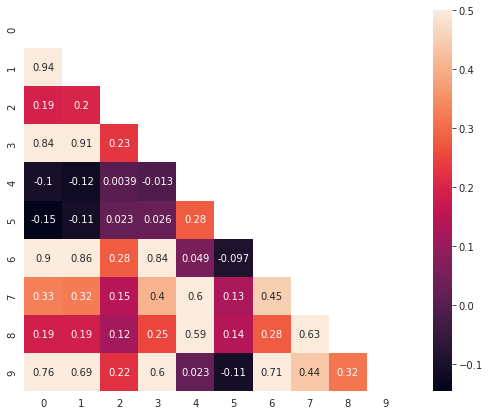

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel


tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/quora-distilbert-base')
model = AutoModel.from_pretrained('./output/sentence-transformers/quora-distilbert-base')

sim = sim_matrix(model)  # build similarity scores matrix
# visualize heatmap
mask = np.zeros_like(sim)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(sim, annot=True, mask=mask, vmax=.5, square=True)

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

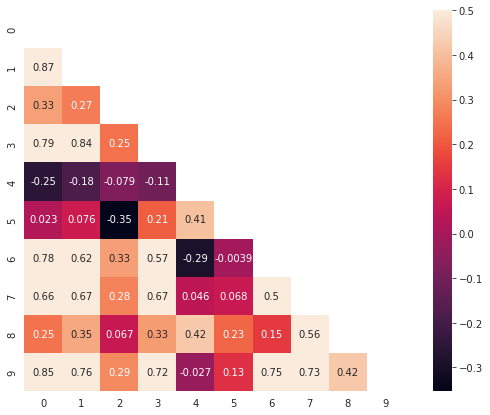

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel


tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/stsb-distilbert-base')
model = AutoModel.from_pretrained('./output/stsb-distilbert-base')

sim = sim_matrix(model)  # build similarity scores matrix
# visualize heatmap
mask = np.zeros_like(sim)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(sim, annot=True, mask=mask, vmax=.5, square=True)